Qubit Resonant Frequency: 0.0000


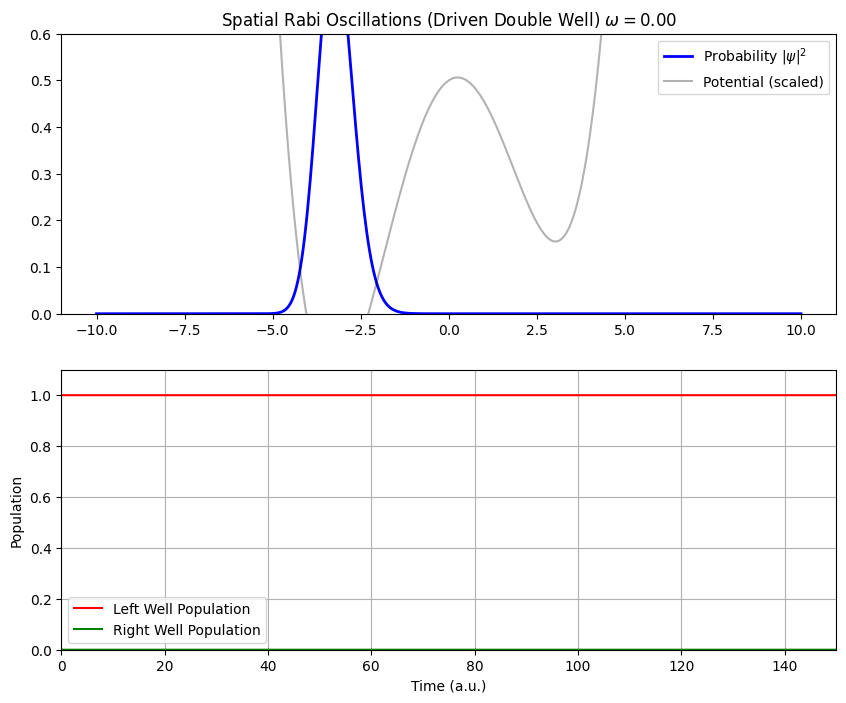

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# --- 1. System Parameters (Atomic Units) ---
hbar = 1.0
m = 1.0

# Spatial Grid
N = 512
L = 20.0
dx = L / N
x = np.linspace(-L/2, L/2, N)
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)

# --- 2. Define The Qubit (Double Well Potential) ---
# V(x) = a*x^4 - b*x^2. Parameters tuned to support two clear states.
a = 0.05
b = 1.0
V_static = a * x**4 - b * x**2
# Shift potential so minima are at roughly 0 energy for convenience
V_static -= np.min(V_static)

# --- 3. Compute Eigenstates (Imaginary Time Evolution) ---
# We need the ground state |g> and excited state |e> to know the resonant frequency.
# This "pre-simulation" calculates the exact energy splitting.
def get_eigenstates(V_pot):
    # Hamiltonian matrix using Finite Difference for quick estimate
    diag = hbar**2 / (m * dx**2) + V_pot
    off_diag = -hbar**2 / (2 * m * dx**2) * np.ones(N-1)
    H_mat = np.diag(diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    evals, evecs = np.linalg.eigh(H_mat)
    return evals, evecs.T

evals, evecs = get_eigenstates(V_static)
E_g = evals[0]
E_e = evals[1]
psi_g = evecs[0]
psi_e = evecs[1]

# Resonant Frequency (The energy gap)
omega_0 = (E_e - E_g) / hbar
print(f"Qubit Resonant Frequency: {omega_0:.4f}")

# Initial State: Localized in the LEFT well.
# We construct this as a superposition: (|g> + |e>) / sqrt(2) approx Left state
psi = (psi_g + psi_e) / np.sqrt(2)
psi /= np.linalg.norm(psi) * np.sqrt(dx) # Normalize

# --- 4. The Rabi Drive Parameters ---
# We drive at exactly the resonant frequency
omega_drive = omega_0 
E_field_amp = 0.5  # Strength of the driving field (Rabi Amplitude)

# Time Stepping
dt = 0.05
# Theoretical Rabi Period T = 2*pi / (mu * E / hbar). 
# Here we just run long enough to see cycles.
t_max = 150.0 
steps = int(t_max / dt)

# --- 5. Split-Operator Propagators ---
# Kinetic (Momentum space)
T_op = np.exp(-1j * (hbar * k)**2 * dt / (2 * m))

# --- 6. Simulation Loop ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot 1: Wavefunction & Potential
line_prob, = ax1.plot(x, np.abs(psi)**2, 'b-', lw=2, label='Probability $|\psi|^2$')
line_pot, = ax1.plot(x, V_static * 0.1, 'k-', alpha=0.3, label='Potential (scaled)')
ax1.set_ylim(0, 0.6)
ax1.set_title(f"Spatial Rabi Oscillations (Driven Double Well) $\omega = {omega_drive:.2f}$")
ax1.legend(loc='upper right')

# Plot 2: Population Inversion (The "Qubit Readout")
# We track probability in Left Well vs Right Well
time_vals = []
pop_L_vals = []
pop_R_vals = []
line_L, = ax2.plot([], [], 'r-', label='Left Well Population')
line_R, = ax2.plot([], [], 'g-', label='Right Well Population')
ax2.set_xlim(0, t_max)
ax2.set_ylim(0, 1.1)
ax2.set_xlabel("Time (a.u.)")
ax2.set_ylabel("Population")
ax2.legend()
ax2.grid(True)

def update(frame):
    global psi
    t = frame * dt
    
    # Time-Dependent Potential: V_static + Dipole Drive
    # V(x,t) = V_static(x) + x * E_amp * cos(wt)
    V_total = V_static + x * E_field_amp * np.cos(omega_drive * t)
    
    # Half-step Potential
    U_V = np.exp(-1j * V_total * dt / (2 * hbar))
    psi = U_V * psi
    
    # Full-step Kinetic
    psi_k = np.fft.fft(psi)
    psi_k = T_op * psi_k
    psi = np.fft.ifft(psi_k)
    
    # Half-step Potential
    psi = U_V * psi
    
    # --- Observables ---
    prob = np.abs(psi)**2
    # Integrate probability in Left (x < 0) and Right (x > 0)
    P_L = np.sum(prob[x < 0]) * dx
    P_R = np.sum(prob[x >= 0]) * dx
    
    # Update Plots
    line_prob.set_ydata(prob)
    # Visualize the "tilting" of the well
    line_pot.set_ydata((V_total) * 0.1)
    
    time_vals.append(t)
    pop_L_vals.append(P_L)
    pop_R_vals.append(P_R)
    
    line_L.set_data(time_vals, pop_L_vals)
    line_R.set_data(time_vals, pop_R_vals)
    
    return line_prob, line_pot, line_L, line_R

# 최대 저장 시간을 max_seconds만큼으로 제한하고자 할 때,
# 저장할 프레임 수를 미리 계산해서 animation에 전달해야 한다.
max_seconds = 1000    # 원하는 최대 저장 시간(초)
max_frames = int(max_seconds / dt)
ani = animation.FuncAnimation(fig, update, frames=max_frames, interval=20, blit=True)

ani.save('quantum_tunneling_Rabi.mp4')
plt.show()

